In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cpu


In [2]:
def get_resnet18():
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(512, 10)
    return model.to(device)

def get_resnet50():
    model = models.resnet50(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(2048, 10)
    return model.to(device)

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=10):
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()

    ori_images = images.data

    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha * images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()

    return images

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.66MB/s]


In [4]:
base_path = '/content/drive/My Drive/adversarial_mnist/saved_models/'

model_names = [
    'Standard ResNet18',
    'Standard ResNet50',
    'Robust ResNet18',
    'Robust ResNet50'
]

file_names = [
    'resnet18_standard_trained.pth',
    'resnet50_standard_trained.pth',
    'resnet18_pgd_robust.pth',
    'resnet50_pgd_robust.pth'
]

models_list = []

print("Loading models...")

m1 = get_resnet18()
m1.load_state_dict(torch.load(base_path + file_names[0], map_location=device))
m1.eval()
models_list.append(m1)

m2 = get_resnet50()
m2.load_state_dict(torch.load(base_path + file_names[1], map_location=device))
m2.eval()
models_list.append(m2)

m3 = get_resnet18()
m3.load_state_dict(torch.load(base_path + file_names[2], map_location=device))
m3.eval()
models_list.append(m3)

m4 = get_resnet50()
m4.load_state_dict(torch.load(base_path + file_names[3], map_location=device))
m4.eval()
models_list.append(m4)

print("All 4 models loaded successfully.")

Loading models...
All 4 models loaded successfully.


In [5]:
num_models = len(models_list)
accuracy_matrix = np.zeros((num_models, num_models))
num_batches = 5

print("Starting Transfer Attack Analysis...")

for i, source_model in enumerate(models_list):
    print(f"Generating attacks from Source: {model_names[i]}")

    generated_attacks = []
    true_labels = []

    batch_count = 0
    for images, labels in test_loader:
        if batch_count >= num_batches:
            break
        images, labels = images.to(device), labels.to(device)
        adv_imgs = pgd_attack(source_model, images, labels)
        generated_attacks.append(adv_imgs)
        true_labels.append(labels)
        batch_count += 1

    generated_attacks = torch.cat(generated_attacks)
    true_labels = torch.cat(true_labels)

    for j, target_model in enumerate(models_list):
        with torch.no_grad():
            outputs = target_model(generated_attacks)
            _, preds = torch.max(outputs, 1)
            correct = (preds == true_labels).sum().item()
            acc = (correct / len(true_labels)) * 100
            accuracy_matrix[i, j] = acc

print("Analysis Complete.")

Starting Transfer Attack Analysis...
Generating attacks from Source: Standard ResNet18
Generating attacks from Source: Standard ResNet50
Generating attacks from Source: Robust ResNet18
Generating attacks from Source: Robust ResNet50
Analysis Complete.


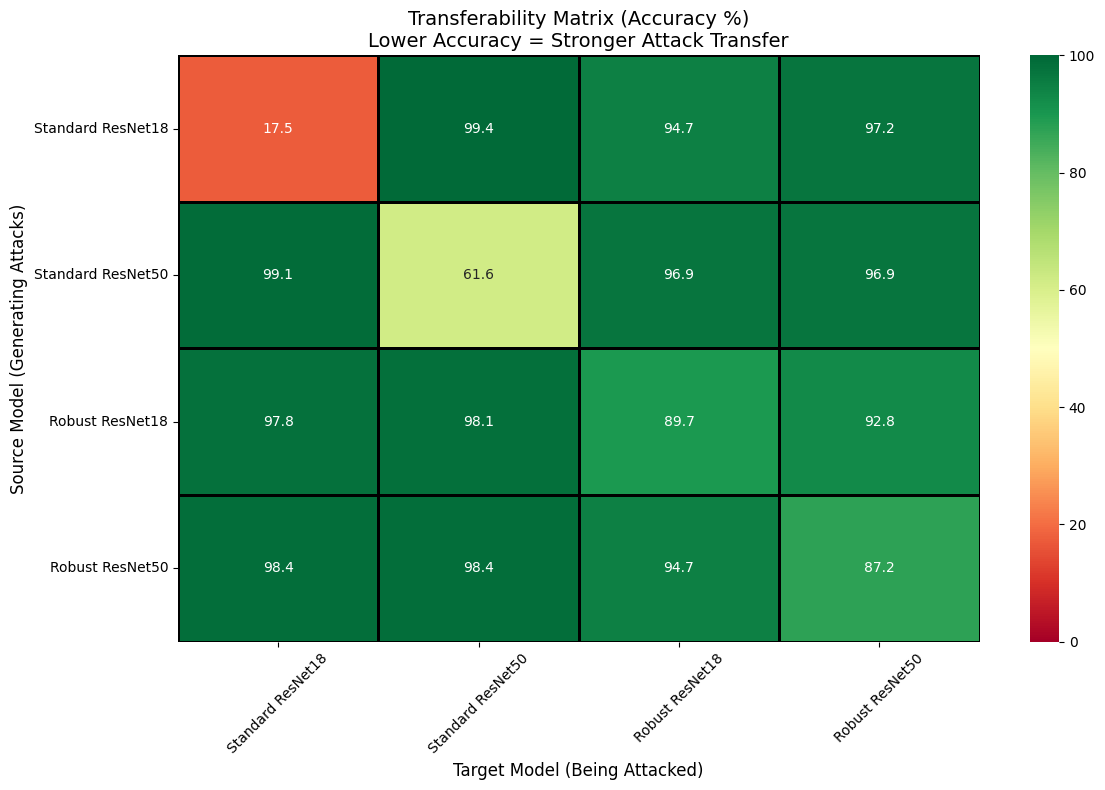

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(accuracy_matrix, annot=True, fmt=".1f", cmap="RdYlGn",
            xticklabels=model_names, yticklabels=model_names,
            vmin=0, vmax=100, linewidths=1, linecolor='black')

plt.title('Transferability Matrix (Accuracy %)\nLower Accuracy = Stronger Attack Transfer', fontsize=14)
plt.xlabel('Target Model (Being Attacked)', fontsize=12)
plt.ylabel('Source Model (Generating Attacks)', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

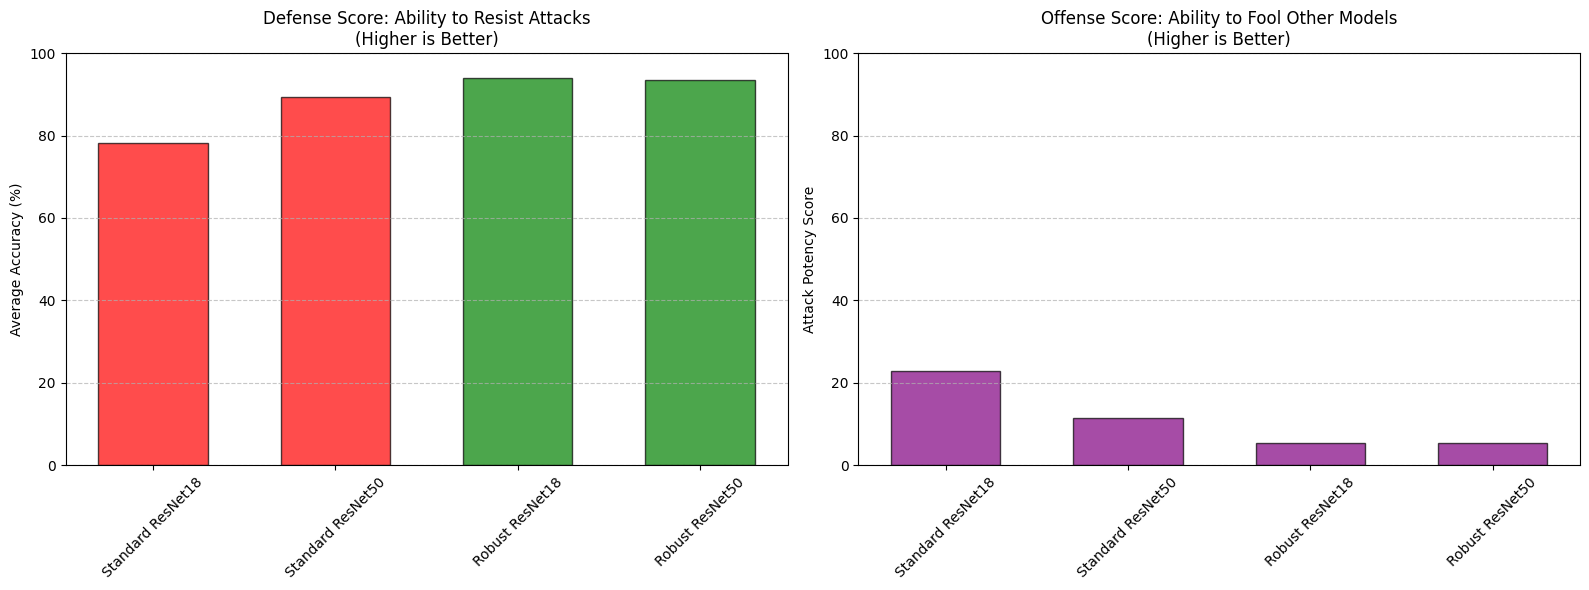

In [7]:
avg_robustness = np.mean(accuracy_matrix, axis=0)
avg_attack_strength = 100 - np.mean(accuracy_matrix, axis=1)

x = np.arange(len(model_names))
width = 0.6

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

colors_def = ['red' if 'Standard' in name else 'green' for name in model_names]
ax[0].bar(x, avg_robustness, width, color=colors_def, alpha=0.7, edgecolor='black')
ax[0].set_ylabel('Average Accuracy (%)')
ax[0].set_title('Defense Score: Ability to Resist Attacks\n(Higher is Better)')
ax[0].set_xticks(x)
ax[0].set_xticklabels(model_names, rotation=45)
ax[0].set_ylim(0, 100)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

ax[1].bar(x, avg_attack_strength, width, color='purple', alpha=0.7, edgecolor='black')
ax[1].set_ylabel('Attack Potency Score')
ax[1].set_title('Offense Score: Ability to Fool Other Models\n(Higher is Better)')
ax[1].set_xticks(x)
ax[1].set_xticklabels(model_names, rotation=45)
ax[1].set_ylim(0, 100)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()